# Introduction: Book Recommendation System

In this notebook, i will build a book recommendation system based on a simple principle: books with Wikipedia pages that link to similar Wikipedia pages are similar to each other. In order to create this representation of similar books, i'll use the concept of neural network entity embeddings, mapping each book and each Wikipedia link (Wikilink) to a 50-number vector.



## Read in Data

The data is stored as json with line for every book. This data contains every single book article on Wikipedia which was parsed in the [Downloading and Parsing Wikipedia Data Notebook](https://github.com/WillKoehrsen/wikipedia-data-science/blob/master/Downloading%20and%20Parsing%20Wikipedia%20Articles.ipynb).

In [ ]:
from IPython.core.interactiveshell import InteractiveShell

# Set shell to show all lines of output
InteractiveShell.ast_node_interactivity = 'all'

In [ ]:
from keras.utils import get_file

x = get_file('found_books_filtered.ndjson', 'https://raw.githubusercontent.com/WillKoehrsen/wikipedia-data-science/master/data/found_books_filtered.ndjson')

import json

books = []

with open(x, 'r') as fin:
    # Append each line to the books
    books = [json.loads(l) for l in fin]

# Remove non-book articles
books_with_wikipedia = [book for book in books if 'Wikipedia:' in book[0]]
books = [book for book in books if 'Wikipedia:' not in book[0]]
print(f'Found {len(books)} books.')

58925764/58925764 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Found 37020 books.


###Data Cleaning
Some non-book articles were included in the dataset and need to be removed.



In [ ]:
[book[0] for book in books_with_wikipedia][:5]

['Wikipedia:Wikipedia Signpost/2014-06-25/Recent research',
 'Wikipedia:New pages patrol/Unpatrolled articles/December 2010',
 'Wikipedia:Templates for discussion/Log/2012 September 23',
 'Wikipedia:Articles for creation/Redirects/2012-10',
 'Wikipedia:Templates for discussion/Log/2012 October 4']

Each book entry includes title, Infobox book data, internal and external Wikipedia links, last edit date, and article length (estimated by character count).





In [ ]:
n = 21
books[n][0], books[n][1], books[n][2][:5], books[n][3][:5], books[n][3][:5], books[n][4], books[n][5]

('Limonov (novel)',
 {'name': 'Limonov',
  'author': 'Emmanuel Carrère',
  'translator': 'John Lambert',
  'country': 'France',
  'language': 'French',
  'publisher': 'P.O.L.',
  'pub_date': '2011',
  'english_pub_date': '2014',
  'pages': '488',
  'isbn': '978-2-8180-1405-9'},
 ['Emmanuel Carrère',
  'biographical novel',
  'Emmanuel Carrère',
  'Eduard Limonov',
  'Prix de la langue française'],
 ['http://www.lefigaro.fr/flash-actu/2011/10/05/97001-20111005FILWWW00615-le-prix-de-la-langue-francaise-a-e-carrere.php',
  'http://www.lexpress.fr/culture/livre/emmanuel-carrere-prix-renaudot-2011_1046819.html',
  'http://limonow.de/carrere/index.html',
  'http://www.tout-sur-limonov.fr/222318809'],
 ['http://www.lefigaro.fr/flash-actu/2011/10/05/97001-20111005FILWWW00615-le-prix-de-la-langue-francaise-a-e-carrere.php',
  'http://www.lexpress.fr/culture/livre/emmanuel-carrere-prix-renaudot-2011_1046819.html',
  'http://limonow.de/carrere/index.html',
  'http://www.tout-sur-limonov.fr/222318

This project  will only use the wikilinks, which are saved as the third element (index 2) for each book.

> Add blockquote



## Map Books to Integers

To facilitate neural network processing, book titles are mapped to unique integer IDs. This mapping allows for efficient representation and retrieval of book information. A reverse mapping from integers back to titles is also created.

In [ ]:
book_index = {book[0]: idx for idx, book in enumerate(books)}
index_book = {idx: book for book, idx in book_index.items()}

book_index['Anna Karenina']
index_book[22494]

22494

'Anna Karenina'

### Exploring Wikilinks

Before proceeding with the main task, a brief exploration of the wikilinks is conducted. This involves identifying the number of unique wikilinks and their frequency distribution using the itertools chain method for list flattening.

In [ ]:
from itertools import chain

wikilinks = list(chain(*[book[2] for book in books]))
print(f"There are {len(set(wikilinks))} unique wikilinks.")

There are 311276 unique wikilinks.


How many of these are links to other books?

In [ ]:
wikilinks_other_books = [link for link in wikilinks if link in book_index.keys()]
print(f"There are {len(set(wikilinks_other_books))} unique wikilinks to other books.")

There are 17032 unique wikilinks to other books.


### Most Linked-to Articles

This section identifies the Wikipedia pages most frequently linked to by books in the dataset. A utility function is defined to count the occurrences of each link, utilizing the collections module for efficient data handling.

In [ ]:
from collections import Counter, OrderedDict

def count_items(l):
    """Return ordered dictionary of counts of objects in `l`"""

    # Create a counter object
    counts = Counter(l)

    # Sort by highest count first and place in ordered dictionary
    counts = sorted(counts.items(), key = lambda x: x[1], reverse = True)
    counts = OrderedDict(counts)

    return counts

To avoid duplicate counts, only unique wikilinks from each book are considered. This involves creating a set of links for each book, flattening the resulting list of sets into a single list, and then utilizing the count_items function to determine the frequency of each link.

In [ ]:
# Find set of wikilinks for each book and convert to a flattened list
unique_wikilinks = list(chain(*[list(set(book[2])) for book in books]))

wikilink_counts = count_items(unique_wikilinks)
list(wikilink_counts.items())[:10]

[('Hardcover', 7489),
 ('Paperback', 7311),
 ('Wikipedia:WikiProject Books', 6043),
 ('Wikipedia:WikiProject Novels', 6015),
 ('English language', 4185),
 ('United States', 3060),
 ('Science fiction', 3030),
 ('The New York Times', 2727),
 ('science fiction', 2502),
 ('novel', 1979)]

Analysis of the most frequently linked pages reveals expected results. However, inconsistencies in capitalization are observed. To address this, all links are converted to lowercase, and the frequency counts are recalculated.

In [ ]:
wikilinks = [link.lower() for link in unique_wikilinks]
print(f"There are {len(set(wikilinks))} unique wikilinks.")

wikilink_counts = count_items(wikilinks)
list(wikilink_counts.items())[:10]

There are 297624 unique wikilinks.


[('paperback', 8740),
 ('hardcover', 8648),
 ('wikipedia:wikiproject books', 6043),
 ('wikipedia:wikiproject novels', 6016),
 ('science fiction', 5665),
 ('english language', 4248),
 ('united states', 3063),
 ('novel', 2983),
 ('the new york times', 2742),
 ('fantasy', 2003)]

The normalization process significantly impacts the link rankings, highlighting the importance of data preprocessing before model training.



#### Remove Most Popular Wikilinks

Common wikilinks, such as those indicating book format (e.g., hardcover, paperback) or Wikipedia project pages, are removed as they provide limited information for content-based recommendations. .

(This step is similar to the idea of [TF-IDF (Term Frequency Inverse Document Frequency](http://www.tfidf.com/). When dealing with words in documents, the words that appear most often across documents are usually not that helpful because they don't distinguish documents. TF-IDF is a way to weight a word higher for appearing more often within an article but decrease the weighting for a word appearing more often between articles.)

In [ ]:
to_remove = ['hardcover', 'paperback', 'hardback', 'e-book', 'wikipedia:wikiproject books', 'wikipedia:wikiproject novels']
for t in to_remove:
    wikilinks.remove(t)
    _ = wikilink_counts.pop(t)

To reduce noise and computational complexity, only wikilinks appearing at least four times are retained for further analysis. This thresholding helps mitigate the impact of infrequent links while maintaining a reasonable training time for the model. Further experimentation with this parameter may be beneficial for optimizing performance.

In [ ]:
# Limit to greater than 3 links
links = [t[0] for t in wikilink_counts.items() if t[1] >= 4]
print(len(links))

41758


#### Most Linked-to Books

This section examines the books most frequently linked to by other books within the dataset. To ensure accurate counts, only unique links to other books are considered, avoiding multiple counts for repeated links.



In [ ]:
# Find set of book wikilinks for each book
unique_wikilinks_books = list(chain(*[list(set(link for link in book[2] if link in book_index.keys())) for book in books]))

# Count the number of books linked to by other books
wikilink_book_counts = count_items(unique_wikilinks_books)
list(wikilink_book_counts.items())[:10]

[('The Encyclopedia of Science Fiction', 127),
 ('The Discontinuity Guide', 104),
 ('The Encyclopedia of Fantasy', 63),
 ('Dracula', 55),
 ('Encyclopædia Britannica', 51),
 ('Nineteen Eighty-Four', 51),
 ('Don Quixote', 49),
 ('The Wonderful Wizard of Oz', 49),
 ("Alice's Adventures in Wonderland", 47),
 ('Jane Eyre', 39)]

It's not surprising that several of these are references. We also see that a few classics make it into the list!

### Additional Cleaning

Further data cleaning could involve consolidating link entities with minor variations (e.g., capitalization differences) to improve accuracy. While manual inspection and consolidation may be time-consuming, it could enhance the quality of the embeddings. However, the current embeddings performed well without this additional step.

In [ ]:
for book in books:
    if 'The New York Times' in book[2] and 'New York Times' in book[2]:
        print(book[0], book[2])
        break

The Big Picture: Who Killed Hollywood? and Other Essays ['Wikipedia:WikiProject Novels', 'Wikipedia:WikiProject Books', 'William Goldman', 'United States', 'English language', 'William Goldman', 'Michael Sragow', 'Good Will Hunting', 'Robin Williams', 'Matt Damon', 'The New York Times', 'The New York Times Company', 'New York Times', 'Category:Cinema of the United States', 'Category:Film production', 'Category:2000 books', 'Category:Books about films', 'Category:Books by William Goldman', 'Category:Show business memoirs']


In [ ]:
wikilink_counts.get('the new york times')
wikilink_counts.get('new york times')

2742

996

## Wikilinks to Index

Similar to the book mapping, wikilinks are also assigned unique integer IDs for efficient processing. A reverse mapping is created to facilitate retrieval of the original wikilink from its integer representation.

In [ ]:
link_index = {link: idx for idx, link in enumerate(links)}
index_link = {idx: link for link, idx in link_index.items()}

link_index['the economist']
index_link[300]
print(f'There are {len(link_index)} wikilinks that will be used.')

300

'the economist'

There are 41758 wikilinks that will be used.


# Supervised Machine Learning Task

With the data cleaned, the next step involves establishing a supervised machine learning task to train the embedding neural network. The task is defined as follows: given a book title and a wikilink, predict whether the link is present within the book's article.

## Build a Training Set

A training set is essential for machine learning models. In this supervised learning approach, the model is trained to predict the legitimacy of a (book, wikilink) pair, indicating whether the link is present in the book's article. The training set is constructed by iterating through each book and recording all (book, wikilink) pairs found within the dataset.

In [ ]:
pairs = []

# Iterate through each book
for book in books:
    # Iterate through the links in the book
    pairs.extend((book_index[book[0]], link_index[link.lower()]) for link in book[2] if link.lower() in links)

len(pairs), len(links), len(books)
pairs[5000]

(772798, 41758, 37020)

(321, 232)

We now have over 770,000 positive examples on which to train! Each pair represents one Wikilink for one book. Let's look at a few examples.

In [ ]:
index_book[pairs[5000][0]], index_link[pairs[5000][1]]

('Slaves in the Family', 'category:american biographies')

In [ ]:
index_book[pairs[900][0]], index_link[pairs[900][1]]

('The Man Who Watched the Trains Go By (novel)',
 'category:belgian novels adapted into films')

Later on we'll create the negative examples by randomly sampling from the links and the books and making sure the resulting pair is not in `pairs`.

In [ ]:
pairs_set = set(pairs)

Just for fun, let's look at the (book, link) pairs that are represented most often in the data.

In [ ]:
x = Counter(pairs)
sorted(x.items(), key = lambda x: x[1], reverse = True)[:5]

[((13337, 31111), 85),
 ((31899, 65), 77),
 ((25899, 8850), 61),
 ((1851, 2629), 57),
 ((25899, 30465), 53)]

In [ ]:
index_book[13337], index_link[31111]
index_book[31899], index_link[65]
index_book[25899], index_link[30465]

("France's Songs of the Bards of the Tyne - 1850", 'joseph philip robson')

('The Early Stories: 1953–1975', 'the new yorker')

('Marthandavarma (novel)', 'kerala sahitya akademi')

There's nothing wrong with books that link to the same page many times. They are just more likely to be trained on since there are more of them.

## Note about Training / Testing Set

In this specific case, a separate validation or testing set is not utilized for embedding computation. The primary objective is to generate high-quality embeddings rather than achieving optimal model accuracy. The prediction task serves as a means to train the network for embedding generation. Evaluation will focus on the embeddings themselves, assessing the proximity of similar books in the embedding space. While a separate validation/testing set is generally recommended to prevent overfitting, in this scenario, utilizing all data for training is prioritized to maximize embedding accuracy.

## Generator For Training Samples

To train the neural network, both positive and negative samples are generated. Positive samples are drawn from the pairs dataset and assigned a label of 1. Negative samples are created by randomly selecting a book and a link, ensuring the pair is not in pairs, and assigning a label of -1 or 0, depending on the chosen regression or classification approach. A generator function is implemented to yield batches of training samples, facilitating incremental training and efficient memory management.

In [ ]:
import numpy as np
import random
random.seed(100)

def generate_batch(pairs, n_positive = 50, negative_ratio = 1.0, classification = False):
    """Generate batches of samples for training"""
    batch_size = n_positive * (1 + negative_ratio)
    batch = np.zeros((batch_size, 3))

    # Adjust label based on task
    #Classification
    ng_label = 0

    # This creates a generator
    while True:
        # randomly choose positive examples
        for idx, (book_id, link_id) in enumerate(random.sample(pairs, n_positive)):
            batch[idx, :] = (book_id, link_id, 1)

        # Increment idx by 1
        idx += 1

        # Add negative examples until reach batch size
        while idx < batch_size:

            # random selection
            random_book = random.randrange(len(books))
            random_link = random.randrange(len(links))

            # Check to make sure this is not a positive example
            if (random_book, random_link) not in pairs_set:

                # Add to batch and increment index
                batch[idx, :] = (random_book, random_link, ng_label)
                idx += 1

        # Make sure to shuffle order
        np.random.shuffle(batch)
        yield {'book': batch[:, 0], 'link': batch[:, 1]}, batch[:, 2]

To get a new batch, call `next` on the generator.

In [ ]:
next(generate_batch(pairs, n_positive = 2, negative_ratio = 2))

({'book': array([25757., 28410.,  7206., 22162., 29814.,  6895.]),
  'link': array([22920., 33217., 34924.,  5588., 11452.,   260.])},
 array([0., 0., 0., 1., 0., 1.]))

In [ ]:
x, y = next(generate_batch(pairs, n_positive = 2, negative_ratio = 2))

# Show a few example training pairs
for label, b_idx, l_idx in zip(y, x['book'], x['link']):
    print(f'Book: {index_book[b_idx]:30} Link: {index_link[l_idx]:40} Label: {label}')

Book: Bag of Bones                   Link: category:novels by stephen king          Label: 1.0
Book: Deep Six (novel)               Link: president of the united states           Label: 1.0
Book: The Counterfeit Man            Link: gerald gardner (wiccan)                  Label: 0.0
Book: Des Imagistes                  Link: august strindberg                        Label: 0.0
Book: The Soul of the Robot          Link: p.c. cast                                Label: 0.0
Book: Soul Music (novel)             Link: peter crowther                           Label: 0.0


The neural network will take in the book index and the link index and try to embed them in such a way that it can predict the label from the embeddings.

# Neural Network Embedding Model
his section details the construction of a neural network classification model for learning entity embeddings. The model takes book and link indices as input and predicts whether the link is present in the book's article. The core components of the model include embedding layers for books and links, a dot product layer to merge embeddings, and a dense layer with sigmoid activation for classification. The dot product, with normalization, computes the cosine similarity between embeddings, encouraging the network to learn similar embeddings for books with similar links.

The model is employing binary cross-entropy as the loss function and a sigmoid activation function to produce output probabilities between 0 and 1. The Adam optimizer is used for parameter updates during training.

In [ ]:
from keras.layers import Input, Embedding, Dot, Reshape, Dense
from keras.models import Model

In [ ]:
def book_embedding_model(embedding_size = 50, classification = False):
    """Model to embed books and wikilinks using the functional API.
       Trained to discern if a link is present in a article"""

    # Both inputs are 1-dimensional
    book = Input(name = 'book', shape = [1])
    link = Input(name = 'link', shape = [1])

    # Embedding the book (shape will be (None, 1, 50))
    book_embedding = Embedding(name = 'book_embedding',
                               input_dim = len(book_index),
                               output_dim = embedding_size)(book)

    # Embedding the link (shape will be (None, 1, 50))
    link_embedding = Embedding(name = 'link_embedding',
                               input_dim = len(link_index),
                               output_dim = embedding_size)(link)

    # Merge the layers with a dot product along the second axis (shape will be (None, 1, 1))
    merged = Dot(name = 'dot_product', normalize = True, axes = 2)([book_embedding, link_embedding])

    # Reshape to be a single number (shape will be (None, 1))
    merged = Reshape(target_shape = [1])(merged)

    # Classification , Using Binary_Crossentropy
        merged = Dense(1, activation = 'sigmoid')(merged)
        model = Model(inputs = [book, link], outputs = merged)
        model.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

    return model

# Instantiate model and show parameters
model = book_embedding_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ book (InputLayer)         │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ link (InputLayer)         │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ book_embedding            │ (None, 1, 50)          │      1,851,000 │ book[0][0]             │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ link_embedding            │ (None, 1, 50)          │      2,087,900 │ link[0][0]             │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dot_product (Dot)         │ (None, 1, 1)           │              0 │ book_embedding[0][0],  │
│                           │                        │                │ link_embedding[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1)              │              0 │ dot_product[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,938,900 (15.03 MB)

 Trainable params: 3,938,900 (15.03 MB)

 Non-trainable params: 0 (0.00 B)

There are nearly 4.0 million weights (parameters) that need to be learned by the neural network. Each of these represents one number in an embedding for one entity. During training, the neural network adjusts these parameters in order to minimize the loss function on the training data.

# Train Model

The neural network model is trained using the generated training data to learn entity embeddings. During training, the model adjusts its parameters to optimize its ability to predict the presence or absence of a link within a book's article. The resulting embeddings provide a vector representation of books and links, capturing their relationships.

Training parameters include batch size, negative ratio, and the number of epochs. A batch size is chosen based on available memory, while the negative ratio and number of epochs are adjusted to achieve optimal performance. Experimentation with these parameters can further enhance model performance.

In [ ]:
n_positive = 1024

gen = generate_batch(pairs, n_positive, negative_ratio = 2)

# Train using fit() instead of fit_generator()
h = model.fit(gen, epochs = 15,
              steps_per_epoch = len(pairs) // n_positive,
              verbose = 2)


Epoch 1/15
754/754 - 38s - 50ms/step - loss: 0.2605
Epoch 2/15
754/754 - 35s - 46ms/step - loss: 0.1159
Epoch 3/15
754/754 - 36s - 48ms/step - loss: 0.0842
Epoch 4/15
754/754 - 36s - 48ms/step - loss: 0.0746
Epoch 5/15
754/754 - 36s - 47ms/step - loss: 0.0695
Epoch 6/15
754/754 - 36s - 48ms/step - loss: 0.0662
Epoch 7/15
754/754 - 35s - 46ms/step - loss: 0.0638
Epoch 8/15
754/754 - 36s - 48ms/step - loss: 0.0621
Epoch 9/15
754/754 - 35s - 46ms/step - loss: 0.0608
Epoch 10/15
754/754 - 36s - 48ms/step - loss: 0.0598
Epoch 11/15
754/754 - 35s - 46ms/step - loss: 0.0589
Epoch 12/15
754/754 - 36s - 48ms/step - loss: 0.0581
Epoch 13/15
754/754 - 35s - 46ms/step - loss: 0.0575
Epoch 14/15
754/754 - 36s - 48ms/step - loss: 0.0570
Epoch 15/15
754/754 - 35s - 47ms/step - loss: 0.0564


The loss decreases as training progresses which should give us confidence the model is learning something!


The entire trained model can be saved and later loaded in so you don't have to repeat the training. It's also possible to save certain layers.

In [ ]:
model.save('first_attempt.h5')

In [ ]:
model.save('Recommender_Model.keras')

In [ ]:
from tensorflow.keras.models import load_model

# Load the model
model = load_model('Recommender_Model.keras')

# Check the model summary (optional)
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 4 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ book (InputLayer)         │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ link (InputLayer)         │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ book_embedding            │ (None, 1, 50)          │      1,851,000 │ book[0][0]             │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ link_embedding            │ (None, 1, 50)          │      2,087,900 │ link[0][0]             │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dot_product (Dot)         │ (None, 1, 1)           │              0 │ book_embedding[0][0],  │
│                           │                        │                │ link_embedding[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1)              │              0 │ dot_product[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 7,877,802 (30.05 MB)

 Trainable params: 3,938,900 (15.03 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,938,902 (15.03 MB)

# Extract Embeddings and Analyze

The trained model has learned - hopefully - representations of books and wikilinks that place similar entities next to one another in the embedding space. To find out if this is the case, we extract the embeddings and use them to find similar books and links.

In [ ]:
# Extract embeddings
book_layer = model.get_layer('book_embedding')
book_weights = book_layer.get_weights()[0]
book_weights.shape

(37020, 50)

Each book is now represented as a 50-dimensional vector.

We need to normalize the embeddings so that the dot product between two embeddings becomes the cosine similarity.

In [ ]:
book_weights = book_weights / np.linalg.norm(book_weights, axis = 1).reshape((-1, 1))
book_weights[0][:10]
np.sum(np.square(book_weights[0]))

array([ 0.01769526,  0.27759078, -0.05216399,  0.01265471, -0.05667922,
       -0.22505926,  0.22640452, -0.05465611,  0.09149095, -0.00251603],
      dtype=float32)

0.9999999

Normalize just means divide each vector by the square root of the sum of squared components.

# Finding Similar Books

We've trained the model and extracted the embeddings - great - but where is the book recommendation system? Now that we have the embeddings, we can use them to recommend books that our model has learned are most similar to a given book.


### Function to Find Most Similar Entities

The function below takes in either a book or a link, a set of embeddings, and returns the `n` most similar items to the query. It does this by computing the dot product between the query and embeddings. Because we normalized the embeddings, the dot product represents the [cosine similarity](http://blog.christianperone.com/2013/09/machine-learning-cosine-similarity-for-vector-space-models-part-iii/) between two vectors. This is a measure of similarity that does not depend on the magnitude of the vector in contrast to the Euclidean distance. (The Euclidean distance would be another valid metric of similary to use to compare the embeddings.)

Once we have the dot products, we can sort the results to find the closest entities in the embedding space. With cosine similarity, higher numbers indicate entities that are closer together, with -1 the furthest apart and +1 closest together.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 15

def find_similar(name, weights, index_name = 'book', n = 10, least = False, return_dist = False, plot = False):
    """Find n most similar items (or least) to name based on embeddings. Option to also plot the results"""

    # Select index and reverse index
    if index_name == 'book':
        index = book_index
        rindex = index_book
    elif index_name == 'page':
        index = link_index
        rindex = index_link

    # Check to make sure `name` is in index
    try:
        # Calculate dot product between book and all others
        dists = np.dot(weights, weights[index[name]])
    except KeyError:
        print(f'{name} Not Found.')
        return

    # Sort distance indexes from smallest to largest
    sorted_dists = np.argsort(dists)

    # Plot results if specified
    if plot:

        # Find furthest and closest items
        furthest = sorted_dists[:(n // 2)]
        closest = sorted_dists[-n-1: len(dists) - 1]
        items = [rindex[c] for c in furthest]
        items.extend(rindex[c] for c in closest)

        # Find furthest and closets distances
        distances = [dists[c] for c in furthest]
        distances.extend(dists[c] for c in closest)

        colors = ['r' for _ in range(n //2)]
        colors.extend('g' for _ in range(n))

        data = pd.DataFrame({'distance': distances}, index = items)

        # Horizontal bar chart
        data['distance'].plot.barh(color = colors, figsize = (10, 8),
                                   edgecolor = 'k', linewidth = 2)
        plt.xlabel('Cosine Similarity');
        plt.axvline(x = 0, color = 'k');

        # Formatting for italicized title
        name_str = f'{index_name.capitalize()}s Most and Least Similar to'
        for word in name.split():
            # Title uses latex for italize
            name_str += ' $\it{' + word + '}$'
        plt.title(name_str, x = 0.2, size = 28, y = 1.05)

        return None

    # If specified, find the least similar
    if least:
        # Take the first n from sorted distances
        closest = sorted_dists[:n]

        print(f'{index_name.capitalize()}s furthest from {name}.\n')

    # Otherwise find the most similar
    else:
        # Take the last n sorted distances
        closest = sorted_dists[-n:]

        # Need distances later on
        if return_dist:
            return dists, closest


        print(f'{index_name.capitalize()}s closest to {name}.\n')

    # Need distances later on
    if return_dist:
        return dists, closest


    # Print formatting
    max_width = max([len(rindex[c]) for c in closest])

    # Print the most similar and distances
    for c in reversed(closest):
        print(f'{index_name.capitalize()}: {rindex[c]:{max_width + 2}} Similarity: {dists[c]:.{2}}')



(We know that this function works if the most similar book is the book itself. Because we multiply the item vector times all the other embeddings, the most similar should be the item itself with a similarity of 1.0.)

In [ ]:
find_similar('War and Peace', book_weights)

Books closest to War and Peace.

Book: War and Peace                Similarity: 1.0
Book: Anna Karenina                Similarity: 0.92
Book: Demons (Dostoevsky novel)    Similarity: 0.92
Book: Poor Folk                    Similarity: 0.92
Book: The Master and Margarita     Similarity: 0.92
Book: Dead Souls                   Similarity: 0.91
Book: Crime and Punishment         Similarity: 0.91
Book: The Idiot                    Similarity: 0.89
Book: Eugene Onegin                Similarity: 0.88
Book: Under Western Eyes (novel)   Similarity: 0.87


In [ ]:
find_similar('Brave New World',book_weights)

Books closest to Brave New World.

Book: Brave New World                                    Similarity: 1.0
Book: Nineteen Eighty-Four                               Similarity: 0.91
Book: A Clockwork Orange (novel)                         Similarity: 0.89
Book: The Illuminatus! Trilogy                           Similarity: 0.87
Book: Shikasta                                           Similarity: 0.86
Book: Lolita                                             Similarity: 0.85
Book: The Marriages Between Zones Three, Four and Five   Similarity: 0.85
Book: The Difference Engine                              Similarity: 0.85
Book: Brideshead Revisited                               Similarity: 0.85
Book: The Alteration                                     Similarity: 0.85


It works! The most similar books make sense at least for _War and Peace._



In [ ]:
find_similar('War and Peace', book_weights, least = True, n = 5)

Books furthest from War and Peace.

Book: Doctor Dolittle's Garden       Similarity: -0.15
Book: The Low Road (novel)           Similarity: -0.16
Book: The Naughtiest Girl Again      Similarity: -0.18
Book: Draft:City Solipsism           Similarity: -0.24
Book: Choix des plus belles fleurs   Similarity: -0.29


The least similar books are quite a grab bag!

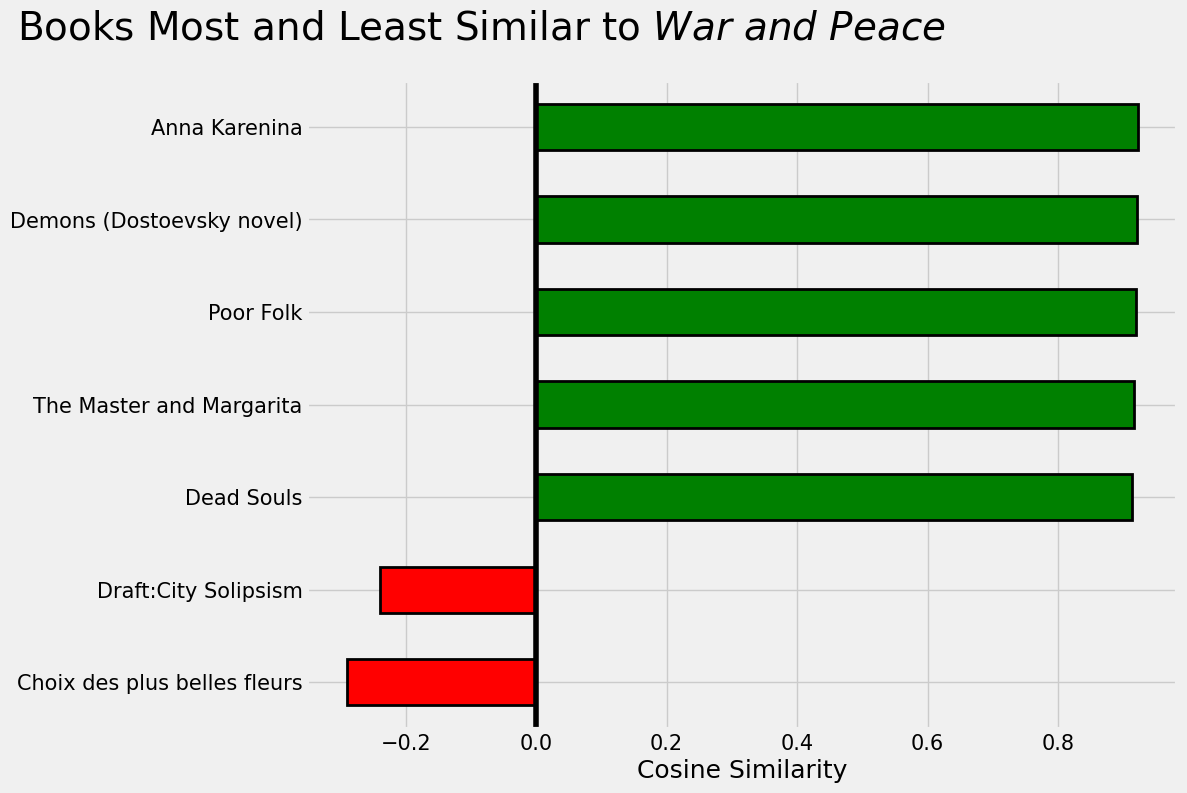

In [ ]:
find_similar('War and Peace', book_weights, n = 5, plot = True)

It doesn't work perfectly for every book as we can see.

In [ ]:
find_similar('Artificial Intelligence: A Modern Approach', book_weights, n = 5)

Books closest to Artificial Intelligence: A Modern Approach.

Book: Artificial Intelligence: A Modern Approach          Similarity: 1.0
Book: Structure and Interpretation of Computer Programs   Similarity: 0.87
Book: Lisp in Small Pieces                                Similarity: 0.87
Book: Hacking: The Art of Exploitation                    Similarity: 0.85
Book: Compilers: Principles, Techniques, and Tools        Similarity: 0.83


In [ ]:
find_similar('Weapons of Math Destruction', book_weights, n = 5)

Books closest to Weapons of Math Destruction.

Book: Weapons of Math Destruction   Similarity: 1.0
Book: The Lucifer Principle         Similarity: 0.86
Book: Bully for Brontosaurus        Similarity: 0.85
Book: A Troublesome Inheritance     Similarity: 0.84
Book: White Rage                    Similarity: 0.84


Not bad by the looks of the results! I encourage you to play around with the model and explore the resulting embeddings. __We have successfully built a book recommendation system using neural network embeddings.__

What should I read next? Currently I'm working through a fantastic collection of essays by Stephen Jay Gould.

In [ ]:
find_similar('Bully for Brontosaurus', book_weights, n = 5)

Books closest to Bully for Brontosaurus.

Book: Bully for Brontosaurus                               Similarity: 1.0
Book: I Have Landed                                        Similarity: 0.92
Book: Leonardo's Mountain of Clams and the Diet of Worms   Similarity: 0.9
Book: Ever Since Darwin                                    Similarity: 0.9
Book: Darwin: The Life of a Tormented Evolutionist         Similarity: 0.89


The algorithm has spoken!

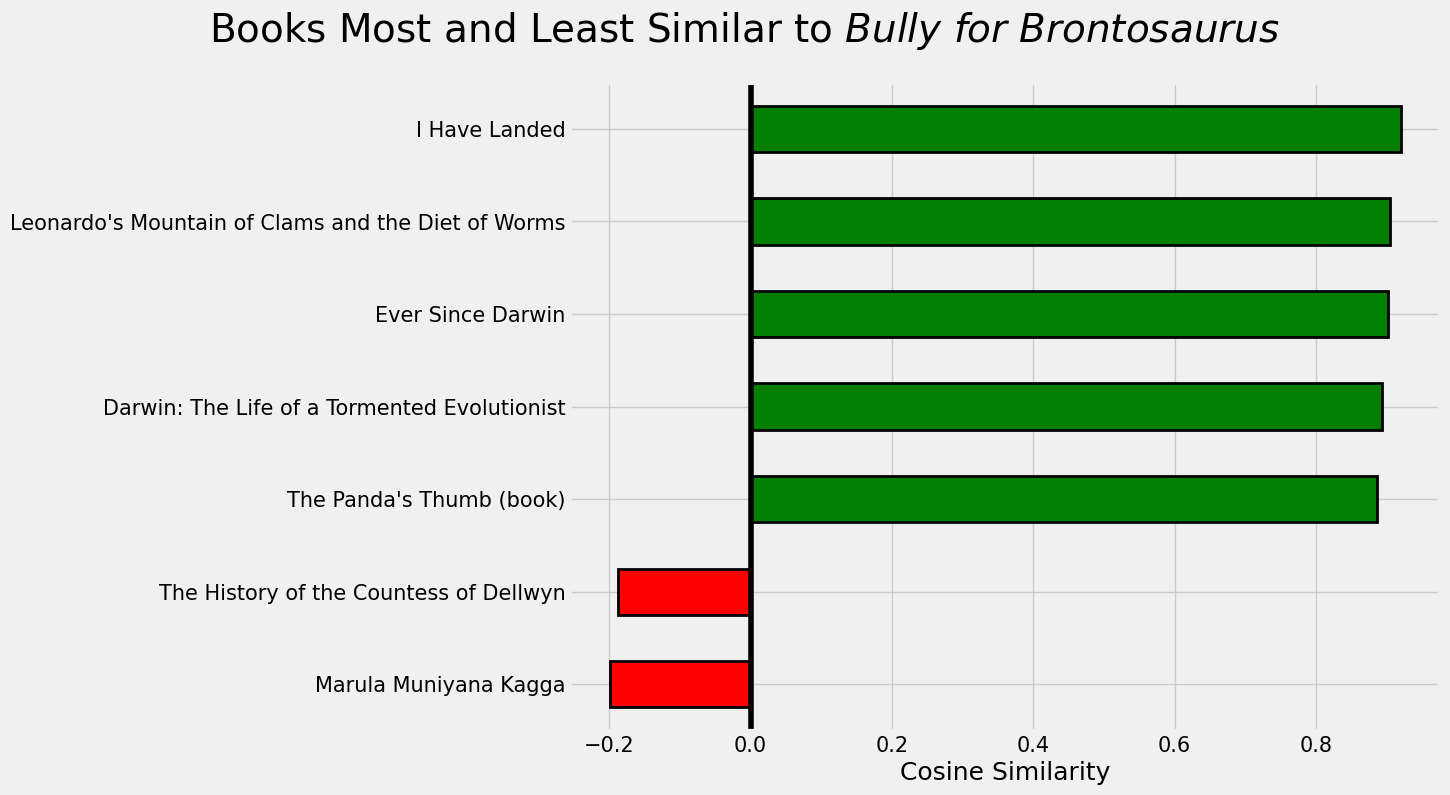

In [ ]:
find_similar('Bully for Brontosaurus', book_weights, n = 5, plot = True)

# Conclusions

This notebook demonstrated the development of a book recommendation system using neural network embeddings. The system leverages the principle that books with similar outgoing links are likely to be similar in content. A supervised machine learning approach was employed, training a neural network to classify the presence or absence of links within book articles.

The resulting embeddings were analyzed to identify similar books based on their proximity in the embedding space. This analysis involved inspecting the embeddings, visualizing their relationships, and reducing their dimensionality for visualization purposes.

The key contributions of this work include:



*   Data cleaning and preprocessing for machine learning.


*   Formulation of a supervised learning task for embedding generation.

*   Training a neural network to learn entity embeddings.



*   Evaluation of embeddings for similarity-based recommendations.


*  Dimensionality reduction for visualization and analysis.









This project demonstrates the potential of neural network embeddings for building effective recommendation systems. Further research could explore the use of external links, infobox information, or other data sources to enhance the system's performance and expand its applicability to other domains.

Will